<a href="https://colab.research.google.com/github/project-ccap/project-ccap.github.io/blob/master/20221notebooks/2021_1011dcgan_tiny_celeba.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# -*- coding: utf-8 -*-

%matplotlib inline
!wget https://project-ccap.github.io/data/tiny_celeba.tgz -O tiny_celeba.tgz
!tar -zxf tiny_celeba.tgz
!pip install japanize_matplotlib

--2021-10-11 05:31:58--  https://project-ccap.github.io/data/tiny_celeba.tgz
Resolving project-ccap.github.io (project-ccap.github.io)... 185.199.108.153, 185.199.109.153, 185.199.110.153, ...
Connecting to project-ccap.github.io (project-ccap.github.io)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15870963 (15M) [application/octet-stream]
Saving to: ‘tiny_celeba.tgz’

tiny_celeba.tgz     100%[===================>]  15.13M  --.-KB/s    in 0.1s    

2021-10-11 05:31:58 (110 MB/s) - ‘tiny_celeba.tgz’ saved [15870963/15870963]



# DCGAN Tutorial

**Author**: `Nathan Inkawhich` <https://github.com/inkawhich>


# はじめに
<!-- # Introduction -->

このチュートリアルでは、例題を用いて DCGAN の紹介をする。
多くの本物の有名人の写真を見せた後，新しい有名人を生成するように生成敵対ネットワーク (GAN) を学習させる。
ここでのコードのほとんどは `pytorch/examples` <https://github.com/pytorch/examples> にある dcgan の実装からのものである。
この文書では， 実装を徹底的に説明し， このモデルがどのように， そしてなぜ動作するのかを明らかにする。
しかし， 心配しないでください。
GAN に関する予備知識は必要ないが， 初めての人には， ボンネットの中で実際に何が起こっているのかを推論するのに時間を費やす必要があるかもしれません。
また， 時間の節約のために， GPU を 1 つまたは 2 つ持っていると便利である。
では，最初から説明しよう。
<!--
This tutorial will give an introduction to DCGANs through an example. 
We will train a generative adversarial network (GAN) to generate new celebrities after showing it pictures of many real celebrities. 
Most of the code here is from the dcgan implementation in `pytorch/examples` <https://github.com/pytorch/examples>, and this document will give a thorough explanation of the implementation and shed light on how and why this model works. 
But don’t worry, no prior knowledge of GANs is required, but it may require a first-timer to spend some time reasoning about what is actually happening under the hood. 
Also, for the sake of time it will help to have a GPU, or two. 
Lets start from the beginning. -->

# 1. 生成敵対ネットワーク Generative Adversarial Networks
<!-- # Generative Adversarial Networks-->

## 1.1 GAN とは？
<!-- ## What is a GAN?-->

GAN は， 学習データの分布を把握することで， その同じ分布から新しいデータを生成できるように，   深層学習モデルに教えるための枠組みである。
GAN は 2014 年 に Ian Goodfellow によって発明され， 論文 [Generative Adversarial Nets](https://papers.nips.cc/paper/5423-generative-adversarial-nets.pdf) で初めて説明された。
GAN は *生成器 generator* と *識別器 discriminator* という 2 つの異なるモデルで構成されている。
生成器の仕事は， 学習画像に似た 「偽」の画像を生成することである。
識別器の役割は， ある画像を見て， それが本物の訓練画像なのか， 生成器からの偽物の画像なのかを出力することである。
識別器の仕事は，ある画像を見て、それが本物の訓練画像か， 生成器の偽物の画像かを出力することである。
訓練中， 生成器は常に識別器を出し抜こうと， より良い偽物を生成し， 識別器はより良い探偵になって本物と偽物の画像を正しく分類するように努力する。
このゲームの均衡は， 生成器があたかも訓練データから直接来たかのような完璧な偽物を生成しているときで，  識別器は生成器の出力が本物か偽物かを常に 50 ％の信頼度で推測することになる。
<!--
GANs are a framework for teaching a DL model to capture the training data’s distribution so we can generate new data from that same distribution. GANs were invented by Ian Goodfellow in 2014 and first described in the paper `Generative Adversarial Nets` <https://papers.nips.cc/paper/5423-generative-adversarial-nets.pdf>.
They are made of two distinct models, a *generator* and a *discriminator*. 
The job of the generator is to spawn ‘fake’ images that look like the training images. 
The job of the discriminator is to look at an image and output whether or not it is a real training image or a
fake image from the generator. 
During training, the generator is constantly trying to outsmart the discriminator by generating better and better fakes, while the discriminator is working to become a better detective and correctly classify the real and fake images. 
The equilibrium of this game is when the generator is generating perfect fakes that look as if they came directly from the training data, and the discriminator is left to always guess at 50% confidence that the generator output is real or fake.
-->

このチュートリアルで使用する表記法を， 識別器から定義する。
$x$ を画像のデータとする。
$D(x)$ は識別器ネットワークで $x$ が生成器ではなく学習データから来たものである確率を (スカラー) で出力する。
ここでは， 画像を扱っているので $D(x)$ の入力は CHW サイズ 3x64x64 の画像である。
直感的には $D(x)$ は $x$ が学習データから来た場合は HIGH $x$ が生成器から来た場合は LOW になるはずである。
$D(x)$ は， 従来の 2 値分類器と考えることもできる。
<!-- Now, lets define some notation to be used throughout tutorial starting with the discriminator. 
Let $x$ be data representing an image. $D(x)$ is the discriminator network which outputs the (scalar) probability that $x$ came from training data rather than the generator. 
Here, since we are dealing with images the input to $D(x)$ is an image of CHW size 3x64x64. 
Intuitively, $D(x)$ should be HIGH when $x$ comes from training data and LOW when $x$ comes from the generator. 
$D(x)$ can also be thought of as a traditional binary classifier. -->


生成器の表記法として $z$ を標準正規分布からサンプリングされた潜在空間ベクトルとします。
$G(z)$ は， 潜在ベクトル $z$ をデータ空間にマッピングする生成器関数を表す。
$G$ の目的は， 学習データの分布（$p_{data}$）を推定し， その推定分布（$p_g$）から偽のサンプルを生成することである。
<!-- For the generator’s notation, let $z$ be a latent space vector sampled from a standard normal distribution. 
$G(z)$ represents the generator function which maps the latent vector $z$ to data-space.
The goal of $G$ is to estimate the distribution that the training data comes from ($p_{data}$) so it can generate fake samples from that estimated distribution ($p_g$). -->

つまり $D(G(z))$ は， 生成器 $G$ の出力が実像である確率(スカラー) である。
[Goodfellow の 論文](https://papers.nips.cc/paper/5423-generative-adversarial-nets.pdf)  に記載されているように， $D$ と $G$ はミニマックスゲームを行い， $D$ は本物と偽物を正しく分類する確率 ($logD(x)$) を最大化しようとし， $G$ は $D$ の出力が偽物であると予測する確率 ($log(1-D(G(x)))$) を最小化しようとしする。
論文より GAN の損失関数は
<!-- So, $D(G(z))$ is the probability (scalar) that the output of the generator $G$ is a real image. As described in `Goodfellow’s paper` <https://papers.nips.cc/paper/5423-generative-adversarial-nets.pdf>, $D$ and $G$ play a minimax game in which $D$ tries to maximize the probability it correctly classifies reals and fakes ($logD(x)$), and $G$ tries to minimize the probability that $D$ will predict its outputs are fake ($log(1-D(G(x)))$).
From the paper, the GAN loss function is -->

\begin{align}
\underset{G}{\text{min}} \underset{D}{\text{max}}V(D,G) = \mathbb{E}_{x\sim p_{data}(x)}\big[\log D(x)\big] + \mathbb{E}_{z\sim p_{z}(z)}\big[\log(1-D(G(z)))\big]\tag{1}
\end{align}

理論的には， このミニマックスゲームの解は $p_g = p_{data}$ となり， 識別器は入力が本物か偽物かをランダムに推測することになる。
しかし GAN の収束理論はまだ盛んに研究されており， 現実にはモデルがこの点まで学習するとは限らない。
<!-- In theory, the solution to this minimax game is where $p_g = p_{data}$, and the discriminator guesses randomly if the inputs are real or fake. 
However, the convergence theory of GANs is still being actively researched and in reality models do not always train to this point. -->

# 2. DCGANとは？

DCGAN は上述の GAN を直接拡張したもだが， 識別器と生成器にそれぞれ畳み込み層と畳み込み変換層を明示的に使用している。
DCGAN は Radfordらが論文 [Unsupervised Representation Learning With Deep Convolutional Generative Adversarial Networks](https://arxiv.org/pdf/1511.06434.pdf)  で初めて発表した。
識別器は strided [`convolution`](https://pytorch.org/docs/stable/nn.html#torch.nn.Conv2d)  層， [`batch norm`](https://pytorch.org/docs/stable/nn.html#torch.nn.BatchNorm2d) 層，
[`LeakyReLU`](https://pytorch.org/docs/stable/nn.html#torch.nn.LeakyReLU)  活性化関数で構成されている。
入力は 3x64x64 の入力画像であり，出力は入力が実データの分布からのものであるというスカラー確率である。
生成器は，[`convolutional-transpose`](https://pytorch.org/docs/stable/nn.html#torch.nn.ConvTranspose2d) 層，バッチノルム層，[`ReLU`](https://pytorch.org/docs/stable/nn.html#relu) 活性化関数で構成されている。
入力は標準正規分布から引き出された潜在的なベクトル $z$ で，出力は 3x64x64 の RGB 画像である。
strided conv-transpose 層により，潜在ベクトルは画像と同じ形状のボリュームに変換される。
この論文では， 最適化手法の設定方法， 損失関数の計算方法， モデルの重みの初期化方法などのヒントも紹介されているが， これらについては後の節で説明する。
<!--
A DCGAN is a direct extension of the GAN described above, except that it explicitly uses convolutional and convolutional-transpose layers in the discriminator and generator, respectively. 
It was first described by Radford et. al. in the paper `Unsupervised Representation Learning With
Deep Convolutional Generative Adversarial Networks` <https://arxiv.org/pdf/1511.06434.pdf>. 
The discriminator is made up of strided `convolution` <https://pytorch.org/docs/stable/nn.html#torch.nn.Conv2d> layers, `batch norm` <https://pytorch.org/docs/stable/nn.html#torch.nn.BatchNorm2d> layers, and
`LeakyReLU` <https://pytorch.org/docs/stable/nn.html#torch.nn.LeakyReLU> activations. 
The input is a 3x64x64 input image and the output is a scalar probability that the input is from the real data distribution.
The generator is comprised of `convolutional-transpose` <https://pytorch.org/docs/stable/nn.html#torch.nn.ConvTranspose2d> layers, batch norm layers, and `ReLU` <https://pytorch.org/docs/stable/nn.html#relu> activations. 
The input is a latent vector, $z$, that is drawn from a standard normal distribution and the output is a 3x64x64 RGB image. 
The strided conv-transpose layers allow the latent vector to be transformed into a volume with the same shape as an image. 
In the paper, the authors also give some tips about how to setup the optimizers, how to calculate the loss functions, and how to initialize the model weights, all of which will be explained in the coming sections. -->

In [5]:
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

ngpu = 1
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

import japanize_matplotlib
from IPython.display import HTML

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

# from https://discuss.pytorch.org/t/how-to-cast-a-tensor-to-another-type/2713/28
torch.set_default_dtype(torch.float32)

Random Seed:  999


# 3. 入力
<!-- # 3. Inputs -->

実行するための入力を定義する。
<!-- Let’s define some inputs for the run:-->

- **dataroot** - データセットのフォルダのルートへのパス。データセットについては， 次節で詳しく説明する。
- **workers** - DataLoader でデータを読み込むためのワーカースレッド数。
- **batch_size** - 学習に使用するバッチサイズ。DCGAN 論文ではバッチサイズ  128 を使用してる。
- **image_size** - 学習に使用する画像の空間サイズ。
   この実装では，デフォルトで 64x64 に設定されている。
別のサイズにしたい場合は，D と G の構造を変更する必要がある。
   詳細については， <https://github.com/pytorch/examples/issues/70> を参照。
- **nc** - 入力画像の色チャンネル数， カラー画像の場合は 3 
- **nz** - 潜在的なベクトルの長さ。
- **ngf** - 生成器で処理される特徴地図の深さに関連
- **ndf** - 識別器を通して伝搬される特徴地図の深さを設定
- **num_epochs** - 実行する学習エポック数。長く学習すれば良い結果が得られるだろうが，それだけ時間もかかる。
- **lr** - 学習時の学習率。DCGAN 論文に記載されているように，この数値は 0.0002 とする。
-  **β1** - Adam 最適化 の β1 ハイパーパラメータ。論文にあるように、この数値は 0.5 であるべき。
- **ngpu** - 利用可能な GPU 数。この値が 0 の場合，コードは CPU モードで実行される。この数字が 0 より大きい場合，その数の GPU で実行される。

<!-- -  **dataroot** - the path to the root of the dataset folder. We will talk more about the dataset in the next section
-  **workers** - the number of worker threads for loading the data with the DataLoader
-  **batch_size** - the batch size used in training. The DCGAN paper uses a batch size of 128
-  **image_size** - the spatial size of the images used for training.
   This implementation defaults to 64x64. If another size is desired, the structures of D and G must be changed. 
   See `here` <https://github.com/pytorch/examples/issues/70> for more details
-  **nc** - number of color channels in the input images. For color images this is 3
-  **nz** - length of latent vector 
-  **ngf** - relates to the depth of feature maps carried through the generator
-  **ndf** - sets the depth of feature maps propagated through the discriminator
-  **num_epochs** - number of training epochs to run. Training for longer will probably lead to better results but will also take much longer
-  **lr** - learning rate for training. As described in the DCGAN paper, this number should be 0.0002
-  **beta1** - beta1 hyperparameter for Adam optimizers. As described in paper, this number should be 0.5 
-  **ngpu** - number of GPUs available. If this is 0, code will run in CPU mode. If this number is greater than 0 it will run on that number of GPUs
 -->


In [ ]:
!ls tiny_celeba

In [43]:
# Root directory for dataset
dataroot = "data/celeba"
dataroot = 'tiny_celeba' #img_align_celeba'

# Number of workers for dataloader
workers = 2
#workers = 4

# Batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 20

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1
#ngpu = 0

# 4. データ
<!-- # Data -->

このチュートリアルでは [Celeb-A Faces dataset](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) を使う。
リンク先のサイト，または [Google Drive](https://drive.google.com/drive/folders/0B7EVK8r0v71pTUZsaXdaSnZBZzg) でダウンロードできる。
<!-- https://drive.google.com/file/d/0B7EVK8r0v71pZjFTYXZWM3FlRnM/view?usp=sharing&resourcekey=0-dYn9z10tMJOBAkviAcfdyQ -->
データセットは *img_align_celeba.zip*というファイル名でダウンロードされる。
ダウンロードが完了したら *celeba* という名前のディレクトリを作成し， そのディレクトリに zip ファイルを解凍する。
そして、このノートブックの *dataroot* 入力を， 先ほど作成した *celeba* ディレクトリに設定してください。
結果として， ディレクトリ構造は次のようになる。
<!--
In this tutorial we will use the `Celeb-A Faces dataset` http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html which can be downloaded at the linked site, or in `Google Drive` <https://drive.google.com/drive/folders/0B7EVK8r0v71pTUZsaXdaSnZBZzg>.
The dataset will download as a file named *img_align_celeba.zip*. 
Once downloaded, create a directory named *celeba* and extract the zip file into that directory. 
Then, set the *dataroot* input for this notebook to the *celeba* directory you just created. The resulting directory structure should be: -->

```
/path/to/celeba
       -> img_align_celeba  
           -> 188242.jpg
           -> 173822.jpg
           -> 284702.jpg
           -> 537394.jpg
              ...
```

これは重要なステップである。
なぜなら ImageFolder データセットクラスを使用するため， データセットのルートフォルダにサブディレクトリがあることが必要だからである。
これで， データセットの作成， データローダの作成， 実行するデバイスの設定， そして最後に訓練データの一部を可視化することができる。 
<!-- This is an important step because we will be using the ImageFolder dataset class, which requires there to be subdirectories in the dataset’s root folder. 
Now, we can create the dataset, create the dataloader, set the device to run on, and finally visualize some of the training data.
-->


In [22]:
!mkdir tiny_celeba/img_align_celeba
!mv tiny_celeba/*.jpg tiny_celeba/img_align_celeba/

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


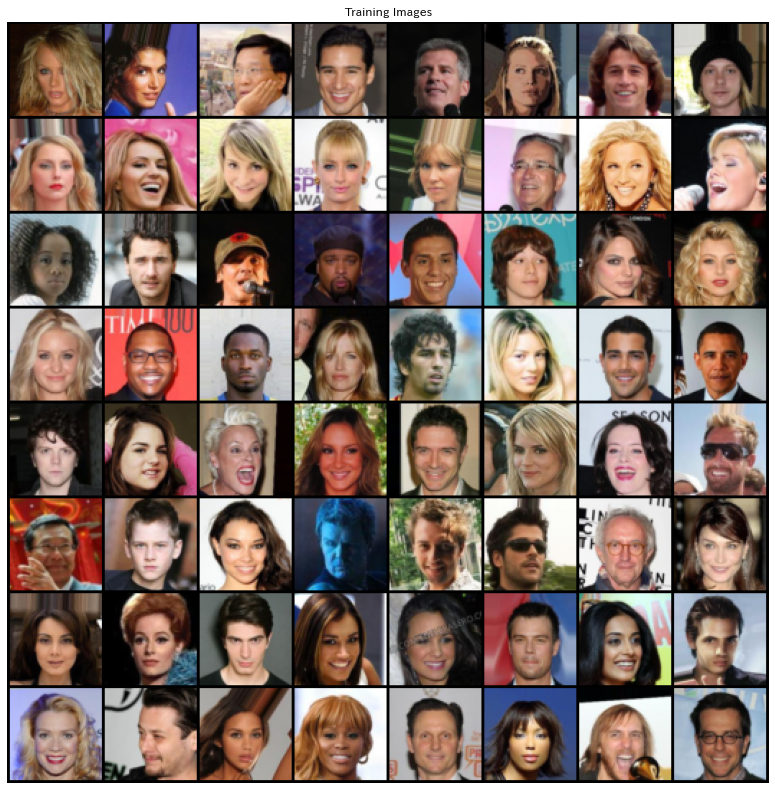

In [28]:
# We can use an image folder dataset the way we have it setup.
# Create the dataset
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(14,14))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


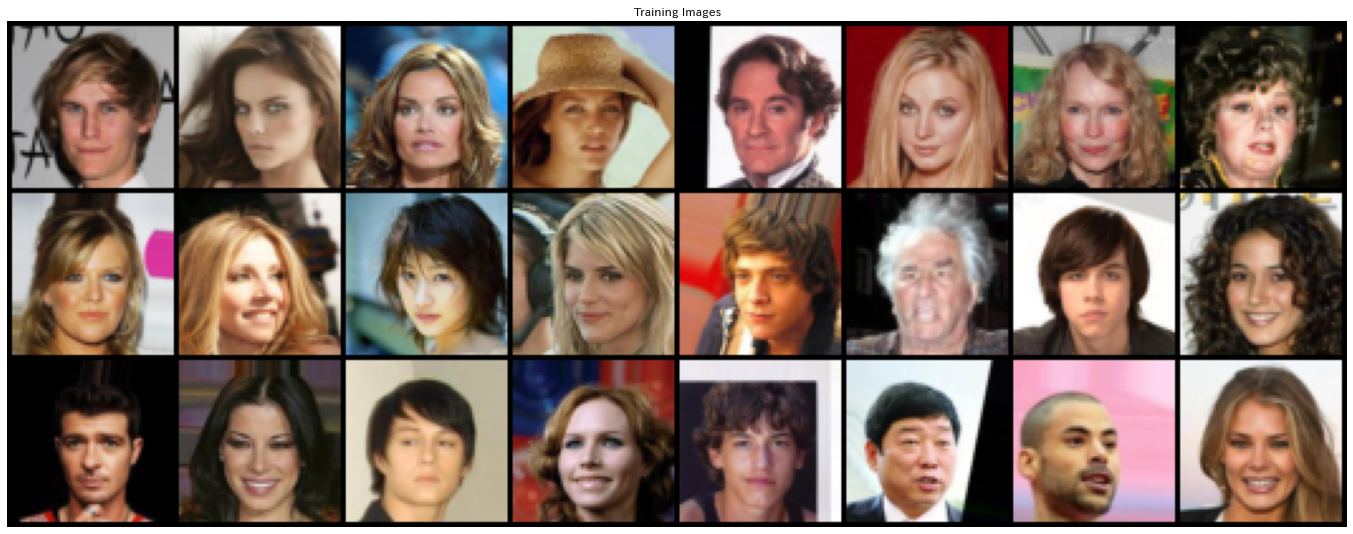

In [29]:
real_batch = next(iter(dataloader))
plt.figure(figsize=(24,12))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:24], padding=2, normalize=True).cpu(),(1,2,0)))

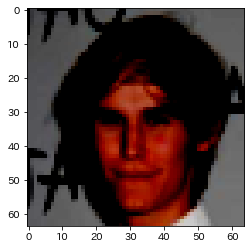

In [30]:
plt.imshow(real_batch[0][0].numpy().transpose(1,2,0).clip(0,1))

# 5. 実装
<!-- # Implementation -->

入力パラメータの設定とデータセットの準備ができたら，いよいよ実装に入る。
まず， 初期化の方法から始めて， 生成器， 識別器， 損失関数， 学習ループについて詳しく説明する。
<!-- With our input parameters set and the dataset prepared, we can now get into the implementation. 
We will start with the weigth initialization strategy, then talk about the generator, discriminator, loss functions, and training loop in detail.-->

# 6. 重みの初期化
<!-- # Weight Initialization -->

DCGAN の論文から， 著者はすべてのモデルの重みを `mean=0`, `stdev=0.02` の正規分布からランダムに初期化することを指定している。
`weights_init` 関数は， 初期化されたモデルを入力とし， この基準を満たすように， すべての畳み込み層， 畳み込み変換層， バッチ正規化層を再初期化する。
この関数は， 初期化後すぐにモデルに適用される。
<!-- From the DCGAN paper, the authors specify that all model weights shall be randomly initialized from a Normal distribution with mean=0, stdev=0.02. 
The ``weights_init`` function takes an initialized model as input and reinitializes all convolutional, convolutional-transpose, and batch normalization layers to meet this criteria. 
This function is applied to the models immediately after initialization.  -->

In [31]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

# 7. 生成器
<!-- # Generator -->

生成器である $G$ は， 潜在空間ベクトル ($z$) をデータ空間にマッピングするように設計されている。
データは画像なので $z$ をデータ空間に変換するということは， 最終的に学習画像と同じサイズ（3x64x64）の RGB 画像を作成することになる。
$z$ をデータ空間に変換するということは， 最終的に学習画像と同じサイズ（3x64x64）の RGB 画像を作成することを意味する。
実際には 2 次元の畳み込み変換層と 2 次元のバッチ・ノルム層，および ReLU  活性化を組み合わせて，この変換を行っている。
生成器の出力は，tanh 関数を介して入力データの範囲 $[-1,1]$ に戻される。
これは DCGAN 論文の重要な貢献であるため，conv-transpose 層の後のバッチノルム関数の存在は注目に値する。
これは DCGAN 論文の重要な貢献である。
これらの層は， 学習中の勾配の流れを助ける。
DCGAN 論文に掲載されている生成器のイメージを以下に示す。
<!--
The generator, $G$, is designed to map the latent space vector ($z$) to data-space. 
Since our data are images, converting $z$ to data-space means ultimately creating a RGB image with the
same size as the training images (i.e. 3x64x64). 
In practice, this is accomplished through a series of strided two dimensional convolutional transpose layers, each paired with a 2d batch norm layer and a relu activation. 
The output of the generator is fed through a tanh function to return it to the input data range of $[-1,1]$. 
It is worth noting the existence of the batch norm functions after the conv-transpose layers, as this is a critical contribution of the DCGAN paper. These layers help with the flow of gradients during training. 
An image of the generator from the DCGAN paper is shown below.
-->
 
<!--.. figure:: /_static/img/dcgan_generator.png
   :alt: dcgan_generator
<img src="dcgan_generator.png" style="width:66%"><br/>
-->
<div align="center">
<img src="https://project-ccap.github.io/figures/dcgan_generator.png" style="width:66%"><br/>
Radford らの論文より    
</div>

入力 節で設定した入力 (*nz*, *ngf*, *nc*) が， コード上の生成器アーキテクチャにどのように影響するかに注目。
*nz*は  $z$  入力ベクトルの長さ，*ngf*は，生成器を介して伝搬される特徴地図のサイズ，*nc* は，出力画像のチャンネル数 (RGB 画像の場合は 3 に設定) である。
以下は，この生成器のコードである。
<!-- Notice, the how the inputs we set in the input section (*nz*, *ngf*, and *nc*) influence the generator architecture in code. *nz* is the length of the z input vector, *ngf* relates to the size of the feature maps that are propagated through the generator, and *nc* is the number of channels in the output image (set to 3 for RGB images). 
Below is the  code for the generator.
 -->



In [32]:
# Generator Code

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

これで， 生成器を実体化して  `weights_init` 関数を適用することができる。
印刷されたモデルを見て， 生成器オブジェクトがどのように構成されているかを確認してみよう。
<!-- Now, we can instantiate the generator and apply the ``weights_init`` function. 
Check out the printed model to see how the generator object is structured. -->



In [33]:
# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


# 8. 識別器
<!-- # Discriminator -->

前述のように，識別器である $D$ は，画像を入力とし， その入力画像が (偽物ではなく) 本物であるかどうかの確率をスカラーで出力する 2 値分類ネットワークである。
ここでは $D$ は 3x64x64 の入力画像を受け取り，Conv2d，BatchNorm2d，LeakyReLU の各層で処理し，シグモイド活性化関数によって最終的な確率を出力している。
このアーキテクチャは， 必要に応じて層を増やすことができる，strided convolution, BatchNorm, LeakyReLUを使用することに意味がある。
DCGAN の論文では， ダウンサンプルにプーリングではなく strided convolution を使用することは， ネットワークに独自のプーリング関数を学習させることができるため， 良い方法であると述べられている。
また，バッチ正則化とリーキー ReLU は $G$ と $D$ の両方の学習過程にとって重要な， 健全な勾配の流れを促進する。
<!-- 
As mentioned, the discriminator, $D$, is a binary classification network that takes an image as input and outputs a scalar probability that the input image is real (as opposed to fake). 
Here, $D$ takes a 3x64x64 input image, processes it through a series of Conv2d, BatchNorm2d, and LeakyReLU layers, and outputs the final probability through a Sigmoid activation function. 
This architecture can be extended with more layers if necessary for the problem, but there is significance to the use of the strided convolution, BatchNorm, and LeakyReLUs. 
The DCGAN paper mentions it is a good practice to use strided convolution rather than pooling to downsample because it lets the network learn its own pooling function. 
Also batch norm and leaky relu functions promote healthy gradient flow which is critical for the learning process of both $G$ and $D$.
-->



識別機のコード <!--Discriminator Code-->

In [34]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

これで， 生成器と同様に，判別器を作成し `weights_init`  関数を適用して，モデルの構造を表示することができる。
<!-- Now, as with the generator, we can create the discriminator, apply the ``weights_init`` function, and print the model’s structure. -->




In [36]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))
    
# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


# 8. 損失関数と最適化関数
<!-- # Loss Functions and Optimizers -->

$D$ と $G$ の設定ができたら， 損失関数と最適化関数を使って学習方法を指定する。
ここでは，2 値化交差エントロピー損失  ([`BCELoss`](https://pytorch.org/docs/stable/nn.html#torch.nn.BCELoss)  関数を用いる。
PyTorch では以下のように定義されている:
<!-- With $D$ and $G$ setup, we can specify how they learn through the loss functions and optimizers. 
We will use the Binary Cross Entropy loss (`BCELoss` <https://pytorch.org/docs/stable/nn.html#torch.nn.BCELoss>)
function which is defined in PyTorch as:  -->

\begin{align}
\ell(x, y) = L = \{l_1,\dots,l_N\}^\top, \quad\\
l_n = - \left[y_n \cdot \log x_n + (1 - y_n) \cdot \log (1 - x_n) \right]
\end{align}

この関数は， 目的関数の両対数成分 (すなわち $\log(D(x))$ と $\log(1-D(G(z)))$) の計算を提供することに注目。
BCE 方程式のどの部分を $y$ の入力に使用するかを指定することができる。
これは下の訓練ループで実現されるが， どのようにして計算したい成分を選択できるかを理解することは重要である。
ここで重要なのは $y$ を変更するだけで，どの成分を計算するかを選択できることである。
<!-- Notice how this function provides the calculation of both log components in the objective function (i.e. $log(D(x))$ and $log(1-D(G(z)))$). 
We can specify what part of the BCE equation to use with the $y$ input. 
This is accomplished in the training loop which is coming up soon, but it is important to understand how we can
choose which component we wish to calculate just by changing $y$ (i.e. GT labels). -->

次に， 本物のラベルを 1， 偽物のラベルを 0 と定義する。
これらのラベルは $D$ と $G$ の損失を計算する際に使用され， これは元の GAN 論文でも使用されている慣習である。
最後に $D$ 用と $G$ 用の 2 つの別々の最適化関数を設定する。
DCGAN 論文で指定されているように， どちらも学習率 0.0002, Beta1 =0.5 の Adam 最適化である。
生成器の学習の進行状況を把握するために， ガウス分布 (つまり 固定ノイズ) から引き出された潜在的なベクトルの固定バッチを生成する。
学習ループでは，この 固定ノイズ を定期的に $G$ に入力し，反復していくうちに
ノイズの中から画像が形成されていく様子を見ることができる。
<!-- Next, we define our real label as 1 and the fake label as 0. 
These labels will be used when calculating the losses of $D$ and $G$, and this is also the convention used in the original GAN paper. 
Finally, we set up two separate optimizers, one for $D$ and one for $G$. 
As specified in the DCGAN paper, both are Adam optimizers with learning rate 0.0002 and Beta1 = 0.5. 
For keeping track of the generator’s learning progression, we will generate a fixed batch of latent vectors that are drawn from a Gaussian distribution (i.e. fixed_noise). 
In the training loop, we will periodically input this fixed_noise into $G$, and over the iterations we will see
images form out of the noise.
-->


In [37]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1
fake_label = 0

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

# 9. 訓練
<!-- # Training -->

最後に GAN の枠組みのすべての部分が定義されたので，それを訓練することができる。
ハイパーパラメータの設定を間違えると，何が悪かったのかほとんど説明できないままモード崩壊してしまうので GAN の訓練はやや芸術的な形式であることに留意して欲しい。
ここでは Goodfellow の論文のアルゴリズム 1 に忠実に従いつつ [ganhacks](https://github.com/soumith/ganhacks) で示されているいくつかのベストプラクティスを遵守する。
具体的には 「本物と偽物の画像に対して異なるミニバッチを作成する」ことと，G の目的関数が $\log D(G(z))$ を最大化するように調整することである。
学習は大きく 2 つのパートに分かれている。
パート1 では 識別器の更新， パート2 では生成器の更新を行う。
<!-- 
Finally, now that we have all of the parts of the GAN framework defined, we can train it. 
Be mindful that training GANs is somewhat of an art form, as incorrect hyperparameter settings lead to mode collapse with little explanation of what went wrong. 
Here, we will closely follow Algorithm 1 from Goodfellow’s paper, while abiding by some of the best practices shown in `ganhacks` <https://github.com/soumith/ganhacks>.
Namely, we will “construct different mini-batches for real and fake” images, and also adjust G’s objective function to maximize $logD(G(z))$. 
Training is split up into two main parts. Part 1 updates the Discriminator and Part 2 updates the Generator. -->

**パート1 - 識別器の訓練**
<!-- **Part 1 - Train the Discriminator** -->

識別器を学習する目的は， 与えられた入力を正しく本物か偽物かに分類する確率を最大化することである。
Goodfellow の言葉を借りれば「確率的勾配を上昇させて識別器を更新する」ということになる。
実際には $\log(D(x)) + \log(1-D(G(x))$ を最大化したい。
ganhacks からの別のミニバッチの提案により， これを 2 つのステップで計算する。
まず，訓練セットから実サンプルのバッチを構築し，$D$ を前向き経路で処理し，損失 ($\log(D(x))$) を計算し，逆向経路で勾配を計算する。
次に，現在の生成器で偽のサンプルのバッチを作成し，このバッチを $D$ に前向き経路に渡し，損失 ($\log(1-D(G(z)))$) を計算する。
そして，逆向経路処理で勾配を蓄積する。
ここで， すべての本物のバッチとすべての偽物のバッチの両方から蓄積された勾配を使って， 識別機の最適化関数のステップを呼び出す。
<!--
Recall, the goal of training the discriminator is to maximize the probability of correctly classifying a given input as real or fake. 
In terms of Goodfellow, we wish to “update the discriminator by ascending its stochastic gradient”. 
Practically, we want to maximize $log(D(x)) + log(1-D(G(z)))$. 
Due to the separate mini-batch suggestion from ganhacks, we will calculate this in two steps. 
First, we will construct a batch of real samples from the training set, forward pass through $D$, calculate the loss ($log(D(x))$), then calculate the gradients in a backward pass. Secondly, we will construct a batch of fake samples with the current generator, forward pass this batch through $D$, calculate the loss ($log(1-D(G(z)))$),
and *accumulate* the gradients with a backward pass. 
Now, with the gradients accumulated from both the all-real and all-fake batches, we call a step of the Discriminator’s optimizer. -->

**パート2 - 生成器の訓練**
<!-- **Part 2 - Train the Generator** -->

オリジナル論文で述べられているように， 我々は，より良い偽物を生成するために $\log(1-D(G(z)))$ を最小化することで生成器を訓練したいと考えている。
前述したように Goodfellow はこの方法では， 特に学習の初期段階では十分な勾配が得られないことを示した。
そこで，代わりに $\log(D(G(z)))$ を最大化することにした。
このコードでは，パート1 の生成器の出力を識別器で分類し，G の損失を計算し， 実ラベルを GT* として使用し， 逆向経路処理で G の勾配を計算し， 最後に最適化関数のステップで G のパラメータを更新することで，これを実現している。
実ラベルを損失関数の GT ラベルとして使用するのは直感的ではないかもしれないが， これにより BCELoss の$\log(x)$ 部分（$\log(1-x)$ 部分ではなく) を使用することができ，これはまさに我々が望むものである。
<!-- 
As stated in the original paper, we want to train the Generator by minimizing $log(1-D(G(z)))$ in an effort to generate better fakes. 
As mentioned, this was shown by Goodfellow to not provide sufficient gradients, especially early in the learning process. 
As a fix, we instead wish to maximize $log(D(G(z)))$. 
In the code we accomplish this by: classifying the Generator output from Part 1 with the Discriminator, computing G’s loss *using real labels as GT*, computing G’s gradients in a backward pass, and finally updating G’s parameters with an optimizer step. 
It may seem counter-intuitive to use the real labels as GT labels for the loss function, but this allows us to use the $log(x)$ part of the BCELoss (rather than the $log(1-x)$ part) which is exactly what we want. -->

最後に，統計情報の報告を行う。
各エポックの終わりに，固定ノイズのバッチをジェネレーターに通して G の訓練の進捗状況を視覚的に確認する。
訓練の統計情報を報告は:
<!-- Finally, we will do some statistic reporting and at the end of each epoch we will push our fixed_noise batch through the generator to visually track the progress of G’s training. 
The training statistics reported are:
-->

- **Loss_D** - すべての本物のバッチとすべての偽物のバッチの損失の合計として計算された識別器の損失 ($\log(D(x)) + \log(D(G(z)))$).
- **Loss_G** - 生成器の損失は $\log(D(G(z)))$ として計算される。
- **D(x)** - すべての現実のバッチに対する識別器の (バッチ全体の) 平均出力。これは 1 に近い値から始まり G が良くなると理論的には 0.5 に収束するはずで ある。この理由を考えてみよう。
- **D(G(z))** - すべての偽のバッチに対する識別器の平均出力。最初の数字は D が更新される前で 2 番目の数字は D が更新された後。これらの数値は 0 に近いところから始まり G が良くなるにつれて 0.5 に収束するはずである。この理由を考えてみよう。

<!-- 
-  **Loss_D** - discriminator loss calculated as the sum of losses for the all real and all fake batches ($log(D(x)) + log(D(G(z)))$).
-  **Loss_G** - generator loss calculated as $log(D(G(z)))$
-  **D(x)** - the average output (across the batch) of the discriminator for the all real batch. This should start close to 1 then theoretically converge to 0.5 when G gets better. Think about why this is.
-  **D(G(z))** - average discriminator outputs for the all fake batch. The first number is before D is updated and the second number is after D is updated. These numbers should start near 0 and converge to 0.5 as G gets better. Think about why this is.
 -->
 
**注** このステップは， 何回エポックを実行したか， データセットからいくつかのデータを削除したかによって，時間がかかることがある。
<!-- **Note:** This step might take a while, depending on how many epochs you run and if you removed some data from the dataset. -->



In [44]:
# 訓練ループ

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):
        
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        #label = torch.full((b_size,), real_label, device=device)
        label = torch.full((b_size,), real_label, device=device).float()

        # Forward pass real batch through D
        #output = netD(real_cpu).view(-1)
        output = netD(real_cpu).view(-1).float()

        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Add the gradients from the all-real and all-fake batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()
        
        # Output training stats
        if i % 50 == 0:
            print(f'[{epoch}/{num_epochs}][{i}/{len(dataloader)}]\t',
                  f'識別器損失: {errD.item():.3f}\t生成器損失: {errG.item():.3f}\t',
                  f'D(x):{D_x:.3f}\tD(G(z)): {D_G_z1:.3f} / {D_G_z2:.3f}')
        
        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())
        
        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
            
        iters += 1

Starting Training Loop...


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[0/20][0/20]	 識別器損失: 1.111	生成器損失: 2.775	 D(x):0.486	D(G(z)): 0.009 / 0.111
[1/20][0/20]	 識別器損失: 0.366	生成器損失: 4.181	 D(x):0.793	D(G(z)): 0.013 / 0.081
[2/20][0/20]	 識別器損失: 0.986	生成器損失: 8.893	 D(x):0.840	D(G(z)): 0.471 / 0.000
[3/20][0/20]	 識別器損失: 0.545	生成器損失: 3.650	 D(x):0.718	D(G(z)): 0.062 / 0.044
[4/20][0/20]	 識別器損失: 1.080	生成器損失: 7.212	 D(x):0.808	D(G(z)): 0.446 / 0.003
[5/20][0/20]	 識別器損失: 0.697	生成器損失: 3.892	 D(x):0.694	D(G(z)): 0.122 / 0.039
[6/20][0/20]	 識別器損失: 0.748	生成器損失: 4.633	 D(x):0.880	D(G(z)): 0.378 / 0.025
[7/20][0/20]	 識別器損失: 0.406	生成器損失: 3.811	 D(x):0.809	D(G(z)): 0.129 / 0.037
[8/20][0/20]	 識別器損失: 0.732	生成器損失: 2.349	 D(x):0.623	D(G(z)): 0.097 / 0.139
[9/20][0/20]	 識別器損失: 0.613	生成器損失: 3.797	 D(x):0.712	D(G(z)): 0.117 / 0.040
[10/20][0/20]	 識別器損失: 0.428	生成器損失: 3.900	 D(x):0.846	D(G(z)): 0.200 / 0.032
[11/20][0/20]	 識別器損失: 0.466	生成器損失: 3.297	 D(x):0.730	D(G(z)): 0.075 / 0.058
[12/20][0/20]	 識別器損失: 0.502	生成器損失: 5.402	 D(x):0.891	D(G(z)): 0.278 / 0.009
[13/20][0/20]	 識別器損失: 

# 10. 結果
<!-- # Results -->

最後に，我々の結果を確認しよう。
ここでは 3 つの異なる結果を見てみよう。
まず D と G の損失が訓練中にどのように変化したかを見る。
次に 固定ノイズバッチでの G の出力をエポックごとに可視化する。
そして 3 つ目は，実データのバッチと G の偽データのバッチを比較する。
<!--
Finally, lets check out how we did. Here, we will look at three different results. 
First, we will see how D and G’s losses changed during training. 
Second, we will visualize G’s output on the fixed_noise batch for every epoch. 
And third, we will look at a batch of real data next to a batch of fake data from G.
-->

## 10.1 損失とトレーニング回数の関係
<!-- **Loss versus training iteration** -->

以下は D と G の損失と訓練の反復回数をプロットしたものである。
<!-- Below is a plot of D & G’s losses versus training iterations.  -->


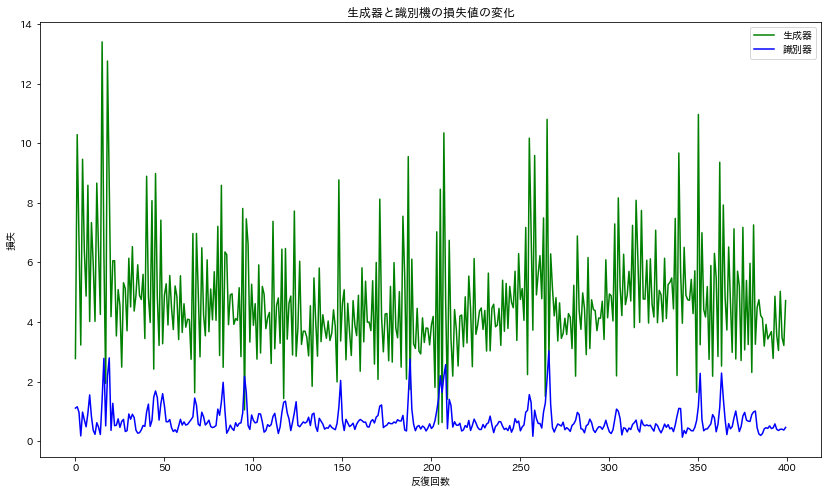

In [45]:
plt.figure(figsize=(14,8))
plt.title("生成器と識別機の損失値の変化")
plt.plot(G_losses,label="生成器", color='green')
plt.plot(D_losses,label="識別器", color='blue')
plt.xlabel("反復回数")
plt.ylabel("損失")
plt.legend()
plt.show()

## 10.2 識別機の学習の視覚化
<!-- **Visualization of G’s progression**  -->

学習の各エポックの後， 固定ノイズバッチに生成器の出力を保存したことを思い出せ。
ここでは G の学習経過をアニメーションで可視化してみよう。
再生ボタンを押すとアニメーションが始まる。
<!--
Remember how we saved the generator’s output on the fixed_noise batch after every epoch of training. 
Now, we can visualize the training progression of G with an animation. 
Press the play button to start the animation.
-->

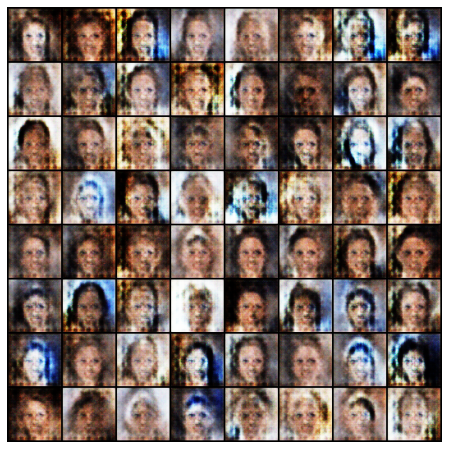

In [46]:
#%%capture
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

## 10.3 本物の画像と偽物の画像の比較

最後に，本物の画像と偽物の画像を並べて見てみまよう。
<!-- **Real Images vs. Fake Images**

Finally, lets take a look at some real images and fake images side by side. -->

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


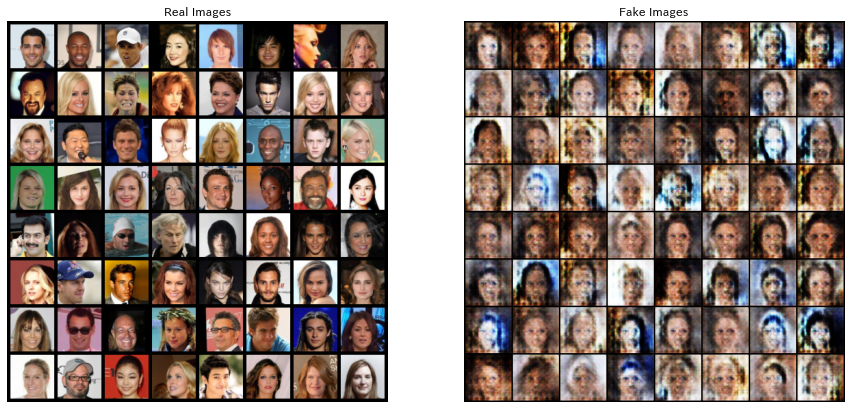

In [47]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

<!-- # Where to Go Next

We have reached the end of our journey, but there are several places you
could go from here. You could:

-  Train for longer to see how good the results get
-  Modify this model to take a different dataset and possibly change the size of the images and the model architecture
-  Check out some other cool GAN projects
   `here` <https://github.com/nashory/gans-awesome-applications>
-  Create GANs that generate `music` <https://deepmind.com/blog/wavenet-generative-model-raw-audio/>

 -->


In [ ]:
#help(netD)

In [ ]:
print(netD.state_dict(), netG.state_dict())
#print(optimizerD.state_dict(), optimizerG.state_dict())
#!pwd

In [ ]:
PATH = '2020-0217_011dcgan_faces2.pth'
torch.save({
            'netD_state_dict': netD.state_dict(),
            'netG_state_dict': netG.state_dict(),
            'optimizerD_state_dict': optimizerD.state_dict(),
            'optimizerG_state_dict': optimizerG.state_dict(),
            }, PATH)

In [ ]:
#!ls -t | head
!file 2020-0217_011dcgan_faces.pth

In [ ]:
print(list(netD.parameters())[5].size())

In [ ]:
np.load()